In [1]:
import jax.numpy as jnp
import jax.numpy.linalg as JLA
from scipy.linalg import block_diag
from scipy.stats import norm
import matplotlib.pyplot as plt

try:
    from probml_utils import pyprobml_utils as pml
except:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import pyprobml_utils as pml

from probml_utils import savefig, latexify, is_latexify_enabled

In [2]:
latexify(width_scale_factor=2, fig_height=2.0)

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
def cov_to_pts(cov):
    """helper function to get covariance interval for plotting, this can likely be included in the utils folder"""
    circ = jnp.linspace(0, 2 * jnp.pi, 100)
    sf = jnp.asarray([jnp.cos(circ), jnp.sin(circ)])
    [u, s, v] = JLA.svd(cov)
    pmat = u * 2.447 * jnp.sqrt(s)  # 95% confidence
    return jnp.dot(pmat, sf)

In [4]:
def gauss_plot2d(plot_dict, save_name=""):

    for key, value in plot_dict.items():
        plt.scatter(value["mu"][0], value["mu"][1], marker="x", c=value["color"])
        plt.plot(*cov_to_pts(value["sigma"]) + value["mu"].reshape(2, 1), "-o", c=value["color"], markersize=0.1)

    # Save figure to files
    if len(save_name) > 0:
        savefig(save_name)

    plt.show()

In [5]:
def calc_posterior(prior, likelihood, W, y):

    # Store Inverse of covariance matrices
    likelihood_sigma_inv = JLA.inv(likelihood["sigma"])
    prior_sigma_inv = JLA.inv(prior["sigma"])

    # Store dimensions of mean matrices, need for reshape later
    likelihood_mu_dim = likelihood["mu"].shape[0]  # 4
    prior_mu_dim = prior["mu"].shape[0]  # 2

    # Calculate posterior covariance and mean
    posterior = {}
    posterior["sigma"] = JLA.inv(prior_sigma_inv + W.T.dot(likelihood_sigma_inv).dot(W))
    posterior["mu"] = posterior["sigma"].dot(
        W.T.dot(likelihood_sigma_inv).dot(y.reshape(likelihood_mu_dim, 1) - likelihood["mu"])
        + prior_sigma_inv.dot(prior["mu"]).reshape(prior_mu_dim, 1)
    )

    # these values are unused
    model = norm(
        loc=W.dot(prior["mu"]) + likelihood["mu"],
        scale=likelihood["sigma"] + W.dot(prior["sigma"]).dot(W.T),
    )
    log_evidence = norm.pdf(y)

    return posterior, log_evidence

In [6]:
def gen_data(sensorf_parm_dict: dict) -> dict:  # Fix Function name

    for value in sensorf_parm_dict.values():

        # Prior mean and variance
        prior = {}
        prior["mu"] = jnp.array([0, 0]).T
        prior["sigma"] = 1e10 * jnp.eye(2)

        # Observed data
        obsrvd_y1 = jnp.array([0, -1]).T
        obsrvd_y2 = jnp.array([1, 0]).T
        obsrvd_all_y = jnp.hstack((obsrvd_y1, obsrvd_y2))

        # Likelihood mean variance
        likelihood = {}
        likelihood["mu"] = jnp.zeros((4, 1))
        likelihood["sigma"] = jnp.array(block_diag(value["sigma"][0], value["sigma"][1]))

        # W - Unsure what this actually means
        W = jnp.tile(jnp.eye(2), (2, 1))

        # Calculate posterior mean and variance
        posterior, log_evidence = calc_posterior(prior, likelihood, W, obsrvd_all_y)

        plot_dict = {
            "y1": {"mu": obsrvd_y1, "sigma": value["sigma"][0], "color": "r"},
            "y2": {"mu": obsrvd_y2, "sigma": value["sigma"][1], "color": "g"},
            "posterior": {
                "mu": posterior["mu"],
                "sigma": posterior["sigma"],
                "color": "k",
            },
        }

        gauss_plot2d(plot_dict, value["save_name"])

In [7]:
sensorf_parm_dict = {
    "Fig(a)": {
        "save_name": "demoGaussBayes2dEqualSpherical",
        "sigma": [0.01 * jnp.eye(2), 0.01 * jnp.eye(2)],
    },
    "Fig(b)": {
        "save_name": "demoGaussBayes2dUnequalSpherical",
        "sigma": [0.05 * jnp.eye(2), 0.01 * jnp.eye(2)],
    },
    "Fig(c)": {
        "save_name": "demoGaussBayes2dUnequal",
        "sigma": [
            0.01 * jnp.array([[10, 1], [1, 1]]),
            0.01 * jnp.array([[1, 1], [1, 10]]),
        ],
    },
}

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


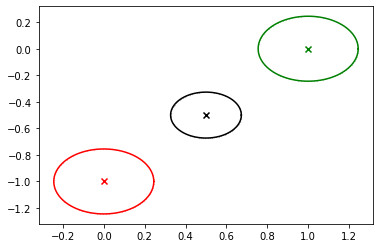

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


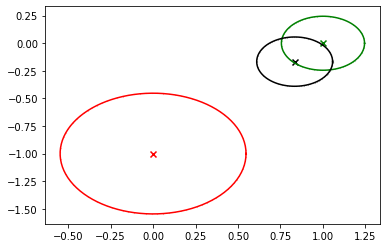

C:\Users\NITISH SHARMA\.pyenv\pyenv-win\versions\3.9.10\lib\site-packages\probml_utils\plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


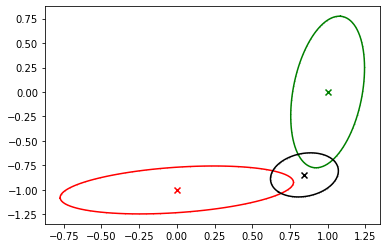

In [8]:
gen_data(sensorf_parm_dict)